# Introduction
In this practical, we implement and train a feed-forward neural network (also known as an "MLP" for "multi-layer perceptron") on a dataset called "Fashion MNIST", consisting of small greyscale images of items of fashion.

# Learning Objectives

* Understand how to use Keras Layers to build a neural network architecture
* Understand how a model is trained and evaluated
* Understand the concept of train/validation/test split and why it's useful

In [5]:
from __future__ import print_function

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf


2023-12-23 04:29:02.181253: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 04:29:02.241970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 04:29:02.242022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 04:29:02.243827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 04:29:02.253464: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-23 04:29:02.254696: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
pip install tensorflow

  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached google_auth-2.25.2-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached Markdown-3.5.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached prot

# Data
In this practical, we use the Fashion MNIST dataset consisting of 70,000 greyscale images and their labels. The dataset is divided
 into 60,000 training images and 10,000 test images. The idea is to train a **classifier** to identify the class value (what type of fashion item it is) given the image. We train and *tune* a model on the 60,000 training images and then evaluate how well it classifies the 10,000 test images that the model did not see during training. This task is an example of a **supervised learning** problem, where we are given both input and labels (targets) to learn from. This is in contrast to **unsupervised learning** where we only have inputs from which to learn patterns or **reinforcement learning** where an agent learns how to maximise a reward signal through interaction with its environment. 

![Texte alternatif…](https://res.cloudinary.com/practicaldev/image/fetch/s---fNWEeWA--/c_imagga_scale,f_auto,fl_progressive,h_420,q_auto,w_1000/https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

# Train/Validation/Test Split

When we build machine learning models, the goal is to build a model that will perform well on future data that we have not seen yet. We say that we want our models to be able to generalise well from whatever training data we can collect and do have available, to whatever data we will be applying them to in future. To do this, we split whatever data we have available into a training set, a validation set and a test set. The idea is that we train our model and use the performance on the validation set to make any adjustments to the model and its hyperparameters, but then we report the final accuracy on the test set. The test set (which we never train on), therefore acts as a proxy for our future data.

In [6]:
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [7]:
# Construct a validation set from the last 10000 images and labels from 
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

In [8]:
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

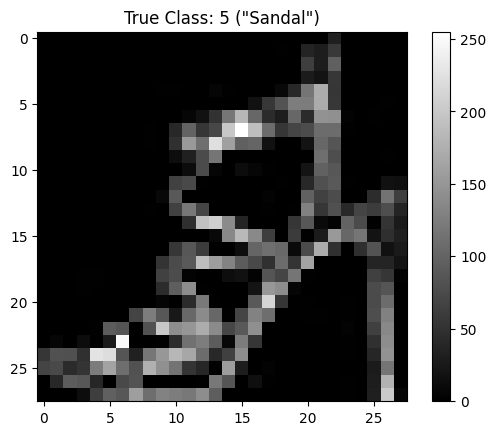

In [13]:
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)
plt.show()

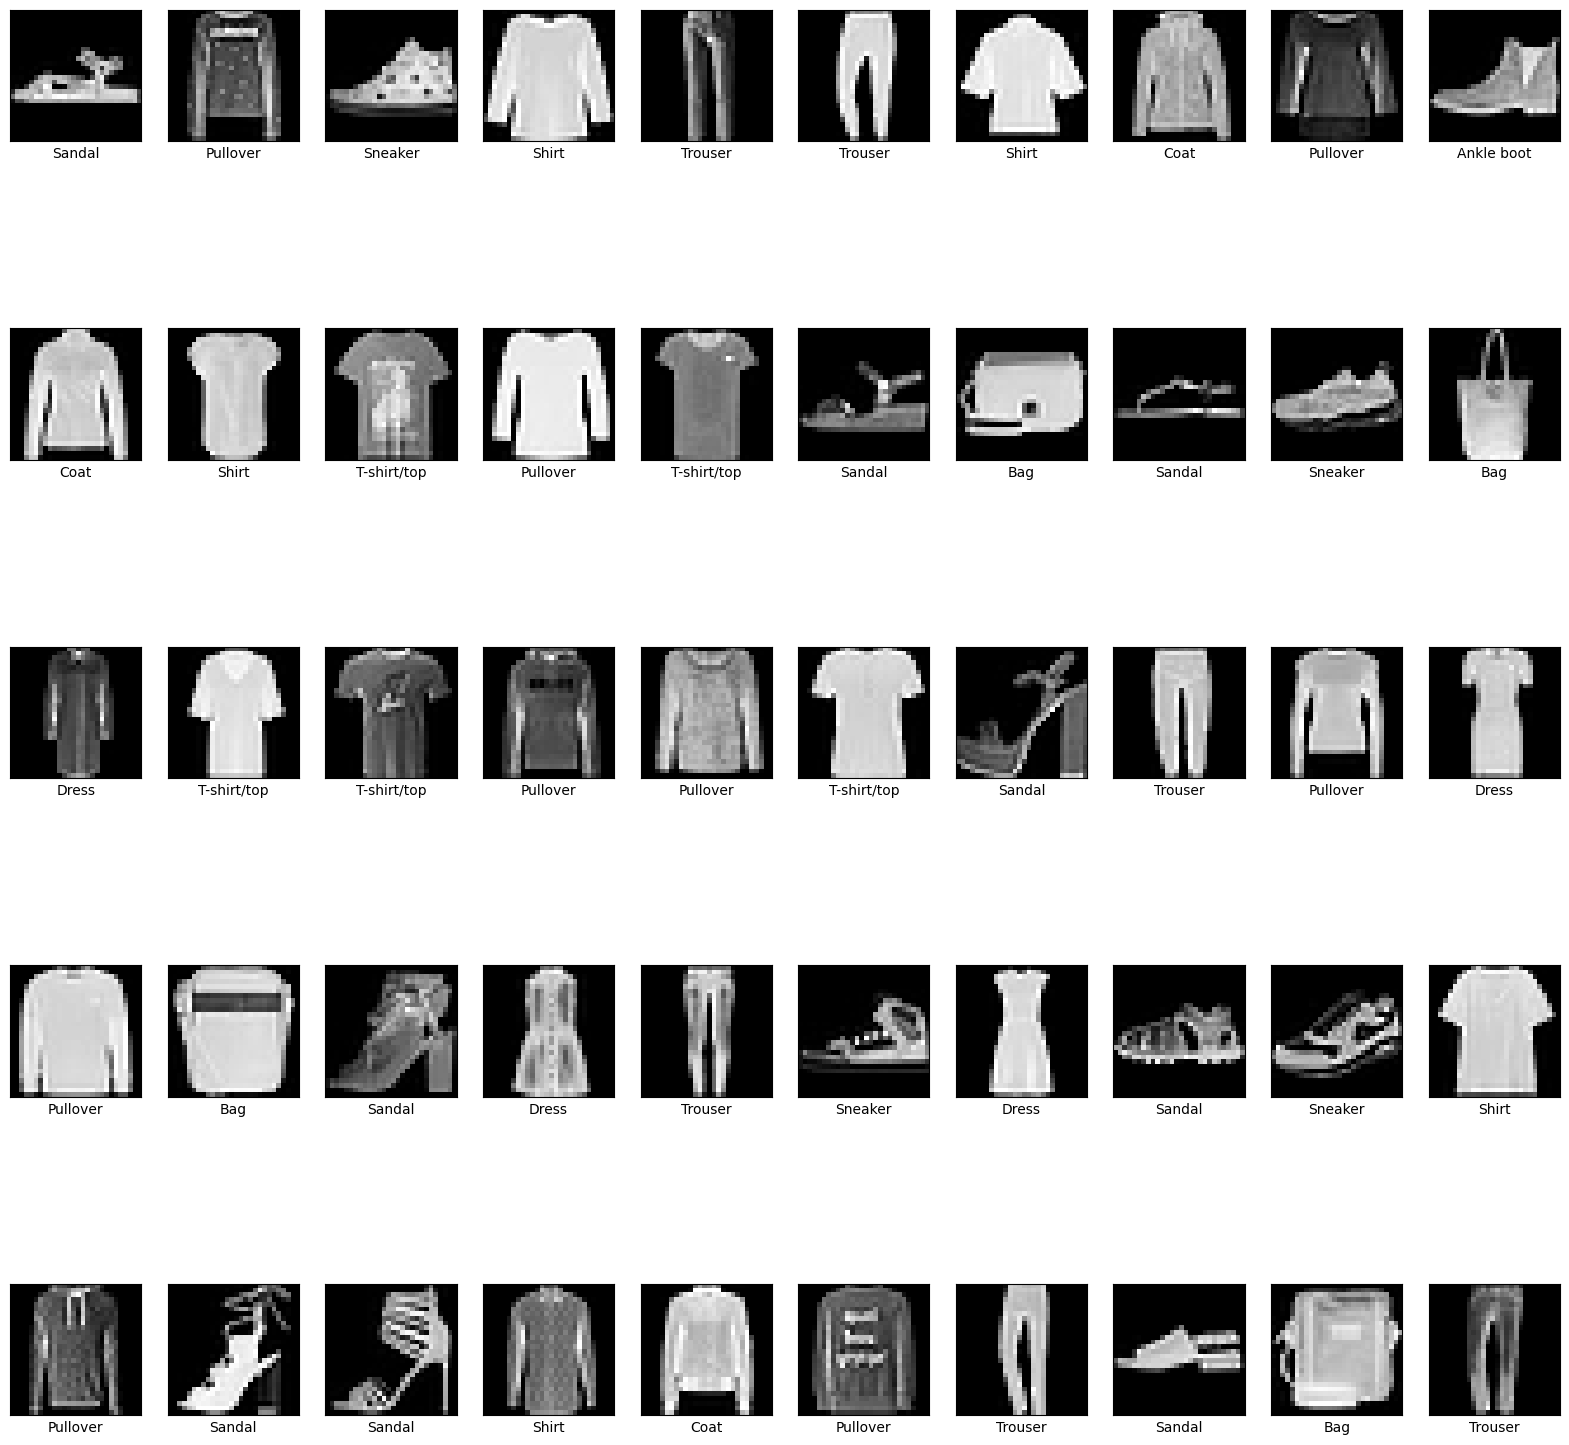

In [14]:
# Another view, showing 50 randomly selected images at a time
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off') # type: ignore
    
    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap=plt.cm.gray) # type: ignore
    plt.xlabel(text_labels[train_labels[img_index]])
    

# Preprocess

In [16]:
# Flatten

train_images_flatten = train_images.reshape(train_images.shape[0], 784)
validation_images_flatten = validation_images.reshape(validation_images.shape[0], 784)
test_images_flatten = test_images.reshape(test_images.shape[0], 784)

In [17]:
# Normalize

train_images_model = train_images_flatten / 255.0
validation_images_model = validation_images_flatten / 255.0
test_images_model = test_images_flatten / 255.0

In [18]:
# convert class vectors to binary class matrices
train_labels_categ = keras.utils.to_categorical(train_labels, 10)
validation_labels_categ = keras.utils.to_categorical(validation_labels, 10)
test_labels_categ = keras.utils.to_categorical(test_labels, 10)

# Train

In [30]:
batch_size = 128
num_classes = 10
epochs = 100

# Create a sequential model here 
model=Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))  # Layer 1: Dense with 256 neurons
model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
model.add(Dense(128, activation='relu'))  # Layer 2: Dense with 128 neurons
model.add(Dense(10, activation='softmax'))  # Output layer with 10 neurons for 10 classes
model.summary()
# End Code

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               200960    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_images_model, train_labels_categ,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validation_images_model, validation_labels_categ))


Epoch 1/100


2023-12-23 04:56:01.963701: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156800000 exceeds 10% of free system memory.


391/391 [==============================] - 4s 8ms/step - loss: 0.6560 - accuracy: 0.7629 - val_loss: 0.4555 - val_accuracy: 0.8342
Epoch 2/100
391/391 [==============================] - 3s 7ms/step - loss: 0.4678 - accuracy: 0.8309 - val_loss: 0.4365 - val_accuracy: 0.8436
Epoch 3/100
391/391 [==============================] - 3s 8ms/step - loss: 0.4266 - accuracy: 0.8450 - val_loss: 0.3925 - val_accuracy: 0.8564
Epoch 4/100
391/391 [==============================] - 3s 7ms/step - loss: 0.4028 - accuracy: 0.8537 - val_loss: 0.3596 - val_accuracy: 0.8708
Epoch 5/100
391/391 [==============================] - 3s 7ms/step - loss: 0.3874 - accuracy: 0.8583 - val_loss: 0.3726 - val_accuracy: 0.8649
Epoch 6/100
391/391 [==============================] - 3s 8ms/step - loss: 0.3741 - accuracy: 0.8641 - val_loss: 0.3767 - val_accuracy: 0.8644
Epoch 7/100
391/391 [==============================] - 3s 8ms/step - loss: 0.3645 - accuracy: 0.8675 - val_loss: 0.3477 - val_accuracy: 0.8753
Epoch 8/100

# Test

In [32]:
score = model.evaluate(test_images_model, test_labels_categ, verbose=0)
print('Test accuracy:', score[1])
# You should be able to get,at least, 88% accuracy

Test accuracy: 0.8784999847412109


In [33]:
test_logits = model.predict(test_images_flatten)

313/313 [==============================] - 1s 3ms/step


In [34]:
test_logits

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994],
       [0.        , 0.        , 0.99999994, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.99999994, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.99999994,
        0.        ],
       [0.        , 0.99999994, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [35]:
test_predictions = np.argmax(test_logits, axis=1)


In [36]:
test_predictions

array([9, 2, 1, ..., 8, 1, 5])

1/1 [==============================] - 0s 21ms/step


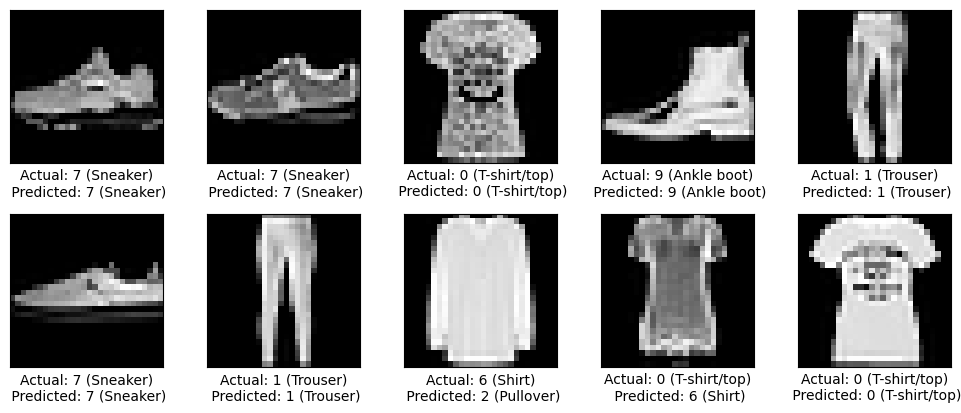

In [38]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off') # type: ignore
    
    img_index = np.random.randint(0, 10000)
    plt.imshow(test_images[img_index], cmap=plt.cm.gray) # type: ignore
    
    actual_label = int(test_labels[img_index])
    predicted_label = np.argmax(model.predict(test_images_flatten[img_index:img_index+1]))
    
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))
    
plt.tight_layout()
plt.show()